# Setup

In [1]:
import pandas as pd
from ucimlrepo import fetch_ucirepo
import numpy as np
from scipy.stats import pointbiserialr
from scipy.stats import chi2_contingency
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from scipy.spatial.distance import squareform

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

In [3]:
import os
os.environ['R_HOME'] = 'C:/Program Files/R/R-4.4.1' 

# import rpy2's package module
from rpy2.robjects.packages import importr
from functools import partial
import rpy2.robjects.packages as rpackages
from rpy2.robjects.vectors import StrVector
from rpy2.ipython import html
html.html_rdataframe=partial(html.html_rdataframe, table_class="docutils")

%load_ext rpy2.ipython

In [ ]:
# from rpy2.robjects.vectors import StrVector

# utils = rpackages.importr('utils')
# package_names = ('tidyverse', 'ggstatsplot')
# utils.install_packages(StrVector(package_names))

In [4]:
%%R 
library(ggplot2)
library(ggstatsplot)

You can cite this package as:
     Patil, I. (2021). Visualizations with statistical details: The 'ggstatsplot' approach.
     Journal of Open Source Software, 6(61), 3167, doi:10.21105/joss.03167


# Data Loading

In [5]:
# fetch dataset 
productivity_prediction_of_garment_employees = fetch_ucirepo(id=597) 

productivity_data = productivity_prediction_of_garment_employees.data
productivity_df = pd.DataFrame(productivity_data['original'])

In [5]:
productivity_df

,date,quarter,department,day,team,targeted_productivity,smv,wip,over_time,incentive,idle_time,idle_men,no_of_style_change,no_of_workers,actual_productivity
0,1/1/2015,Quarter1,sweing,Thursday,8,0.80,26.16,1108.0,7080,98,0.0,0,0,59.0,0.940725
1,1/1/2015,Quarter1,finishing,Thursday,1,0.75,3.94,NaN,960,0,0.0,0,0,8.0,0.886500
2,1/1/2015,Quarter1,sweing,Thursday,11,0.80,11.41,968.0,3660,50,0.0,0,0,30.5,0.800570
3,1/1/2015,Quarter1,sweing,Thursday,12,0.80,11.41,968.0,3660,50,0.0,0,0,30.5,0.800570
4,1/1/2015,Quarter1,sweing,Thursday,6,0.80,25.90,1170.0,1920,50,0.0,0,0,56.0,0.800382
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1192,3/11/2015,Quarter2,finishing,Wednesday,10,0.75,2.90,NaN,960,0,0.0,0,0,8.0,0.628333
1193,3/11/2015,Quarter2,finishing,Wednesday,8,0.70,3.90,NaN,960,0,0.0,0,0,8.0,0.625625
1194,3/11/2015,Quarter2,finishing,Wednesday,7,0.65,3.90,NaN,960,0,0.0,0,0,8.0,0.625625
1195,3/11/2015,Quarter2,finishing,Wednesday,9,0.75,2.90,NaN,1800,0,0.0,0,0,15.0,0.505889


In [6]:
def dataframe_info(df):
    report = pd.DataFrame(columns=['Column', 'Data Type', 'Unique Count', 'Unique Sample', 'Missing Values', 'Missing Percentage'])
    for column in df.columns:
        data_type = df[column].dtype
        unique_count = df[column].nunique()
        unique_sample = df[column].unique()[:5]
        missing_values = df[column].isnull().sum()
        missing_percentage = (missing_values / len(df)) * 100
        report = pd.concat([report, pd.DataFrame({'Column': [column],
                                                      'Data Type': [data_type],
                                                      'Unique Count': [unique_count],
                                                      'Unique Sample': [unique_sample],
                                                      'Missing Values': [missing_values],
                                                      'Missing Percentage': [missing_percentage.round(4)]})],
                             ignore_index=True)
    return report

In [8]:
dataframe_info(productivity_df).set_index('Column')

,Data Type,Unique Count,Unique Sample,Missing Values,Missing Percentage
Column,,,,,
date,object,59,"[1/1/2015, 1/3/2015, 1/4/2015, 1/5/2015, 1/6/2...",0,0.0000
quarter,object,5,"[Quarter1, Quarter2, Quarter3, Quarter4, Quart...",0,0.0000
department,object,2,"[sweing, finishing]",0,0.0000
day,object,6,"[Thursday, Saturday, Sunday, Monday, Tuesday]",0,0.0000
team,int64,12,"[8, 1, 11, 12, 6]",0,0.0000
targeted_productivity,float64,9,"[0.8, 0.75, 0.7, 0.65, 0.6]",0,0.0000
smv,float64,70,"[26.16, 3.94, 11.41, 25.9, 28.08]",0,0.0000
wip,float64,548,"[1108.0, nan, 968.0, 1170.0, 984.0]",506,42.2723
over_time,int64,143,"[7080, 960, 3660, 1920, 6720]",0,0.0000


In [8]:
productivity_df.shape

(1197, 15)

In [9]:
#change date to datetime data type
productivity_df['date'] = pd.to_datetime(productivity_df['date'])
# Extract day of the month from date
productivity_df['day_of_month'] = pd.to_datetime(productivity_df['date']).dt.day

# Extract month from date
productivity_df['month'] = pd.to_datetime(productivity_df['date']).dt.month.astype('object')


# EDA

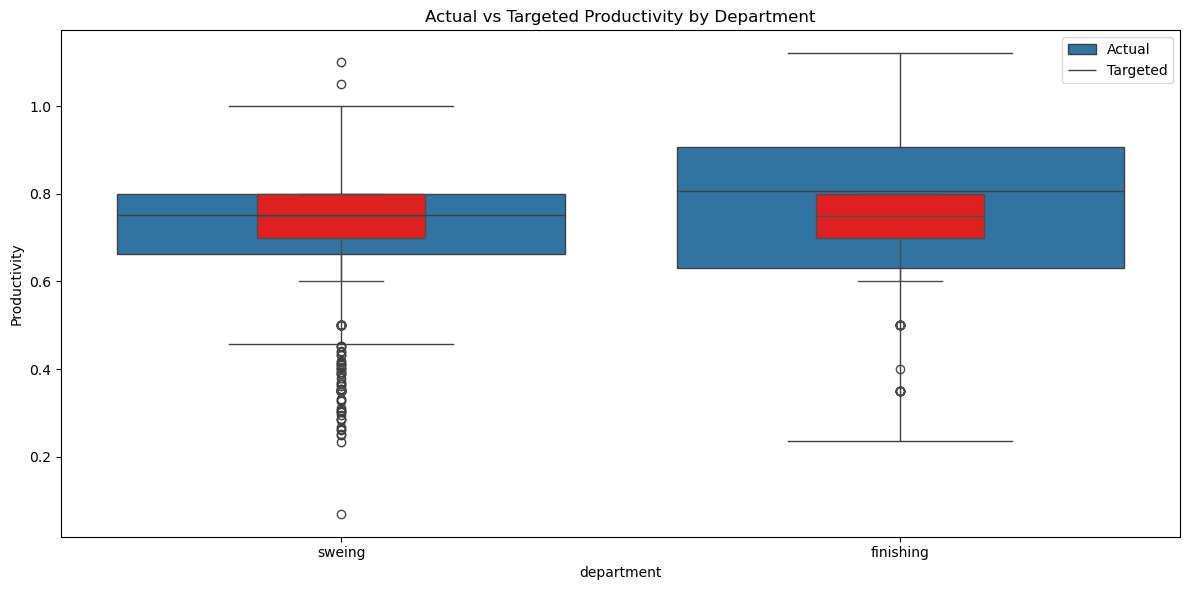

In [12]:
# By Department
plt.figure(figsize=(12, 6))
sns.boxplot(x='department', y='actual_productivity', data=productivity_df)
sns.boxplot(x='department', y='targeted_productivity', data=productivity_df, color='red', width=0.3)
plt.title('Actual vs Targeted Productivity by Department')
plt.ylabel('Productivity')
plt.legend(labels=['Actual', 'Targeted'])
plt.tight_layout()
plt.show()

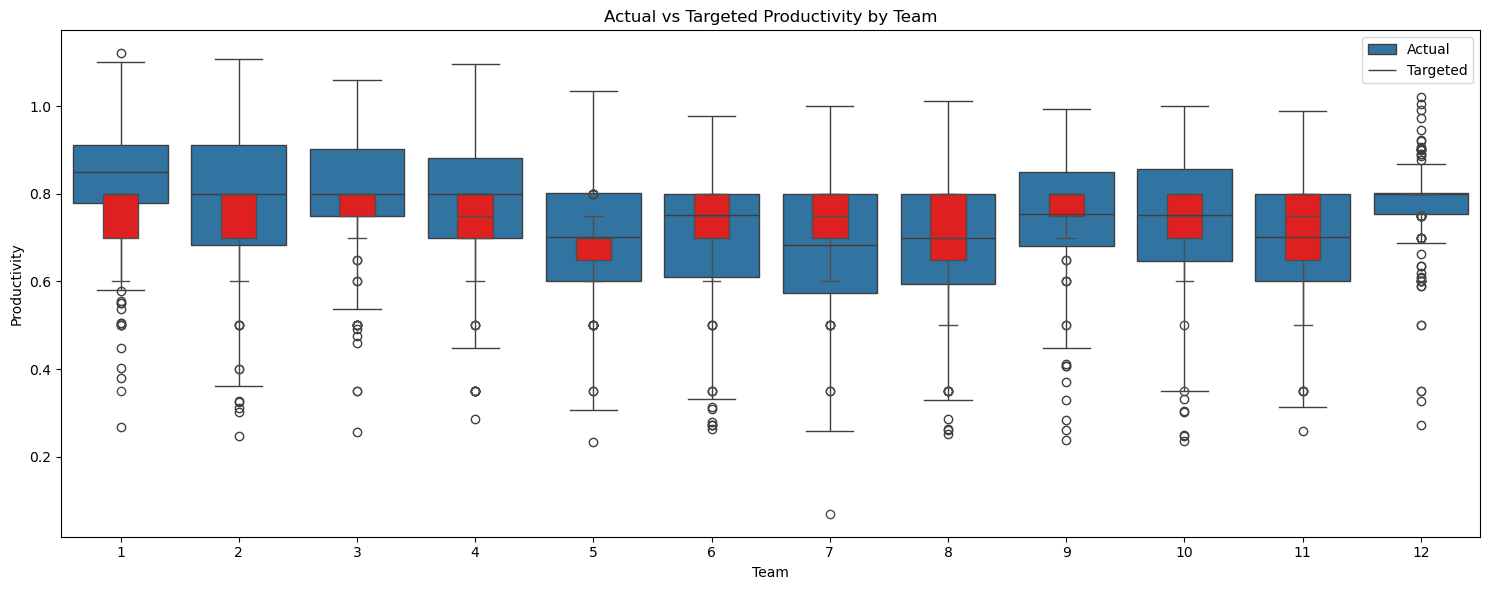

In [13]:
# By Team
plt.figure(figsize=(15, 6))
sns.boxplot(x='team', y='actual_productivity', data=productivity_df)
sns.boxplot(x='team', y='targeted_productivity', data=productivity_df, color='red', width=0.3)
plt.title('Actual vs Targeted Productivity by Team')
plt.xlabel('Team')
plt.ylabel('Productivity')
plt.legend(labels=['Actual', 'Targeted'])
plt.tight_layout()
plt.show()


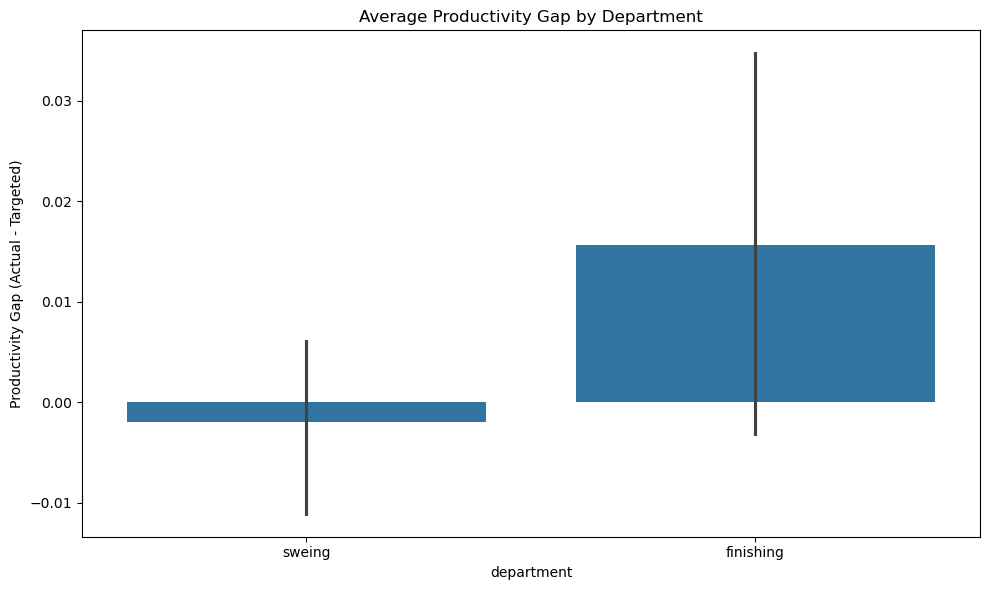

In [17]:
# Additional analysis: Productivity gap by department and team
productivity_df['productivity_gap'] = productivity_df['actual_productivity'] - productivity_df['targeted_productivity']

# Productivity Gap by Department
plt.figure(figsize=(10, 6))
sns.barplot(x='department', y='productivity_gap', data=productivity_df)
plt.title('Average Productivity Gap by Department')
plt.ylabel('Productivity Gap (Actual - Targeted)')
plt.tight_layout()
plt.show()

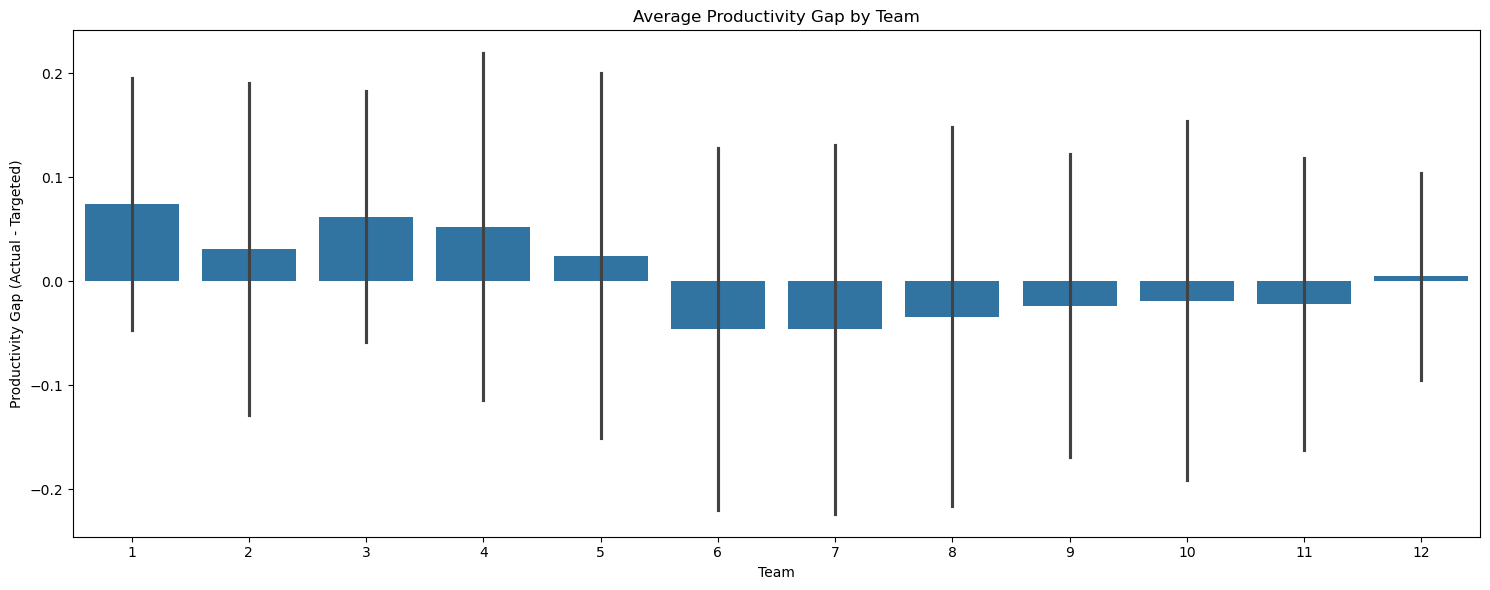

In [18]:
# Productivity Gap by Team
plt.figure(figsize=(15, 6))
sns.barplot(x='team', y='productivity_gap', data=productivity_df, ci='sd')
plt.title('Average Productivity Gap by Team')
plt.xlabel('Team')
plt.ylabel('Productivity Gap (Actual - Targeted)')
plt.tight_layout()
plt.show()

In [19]:
# Print summary statistics
dept_gap = productivity_df.groupby('department')['productivity_gap'].agg(['mean', 'std'])
print("Productivity Gap by Department:")
print(dept_gap)

Productivity Gap by Department:
                mean       std
department                    
finishing   0.015599  0.208987
sweing     -0.001967  0.111009


## Univariate

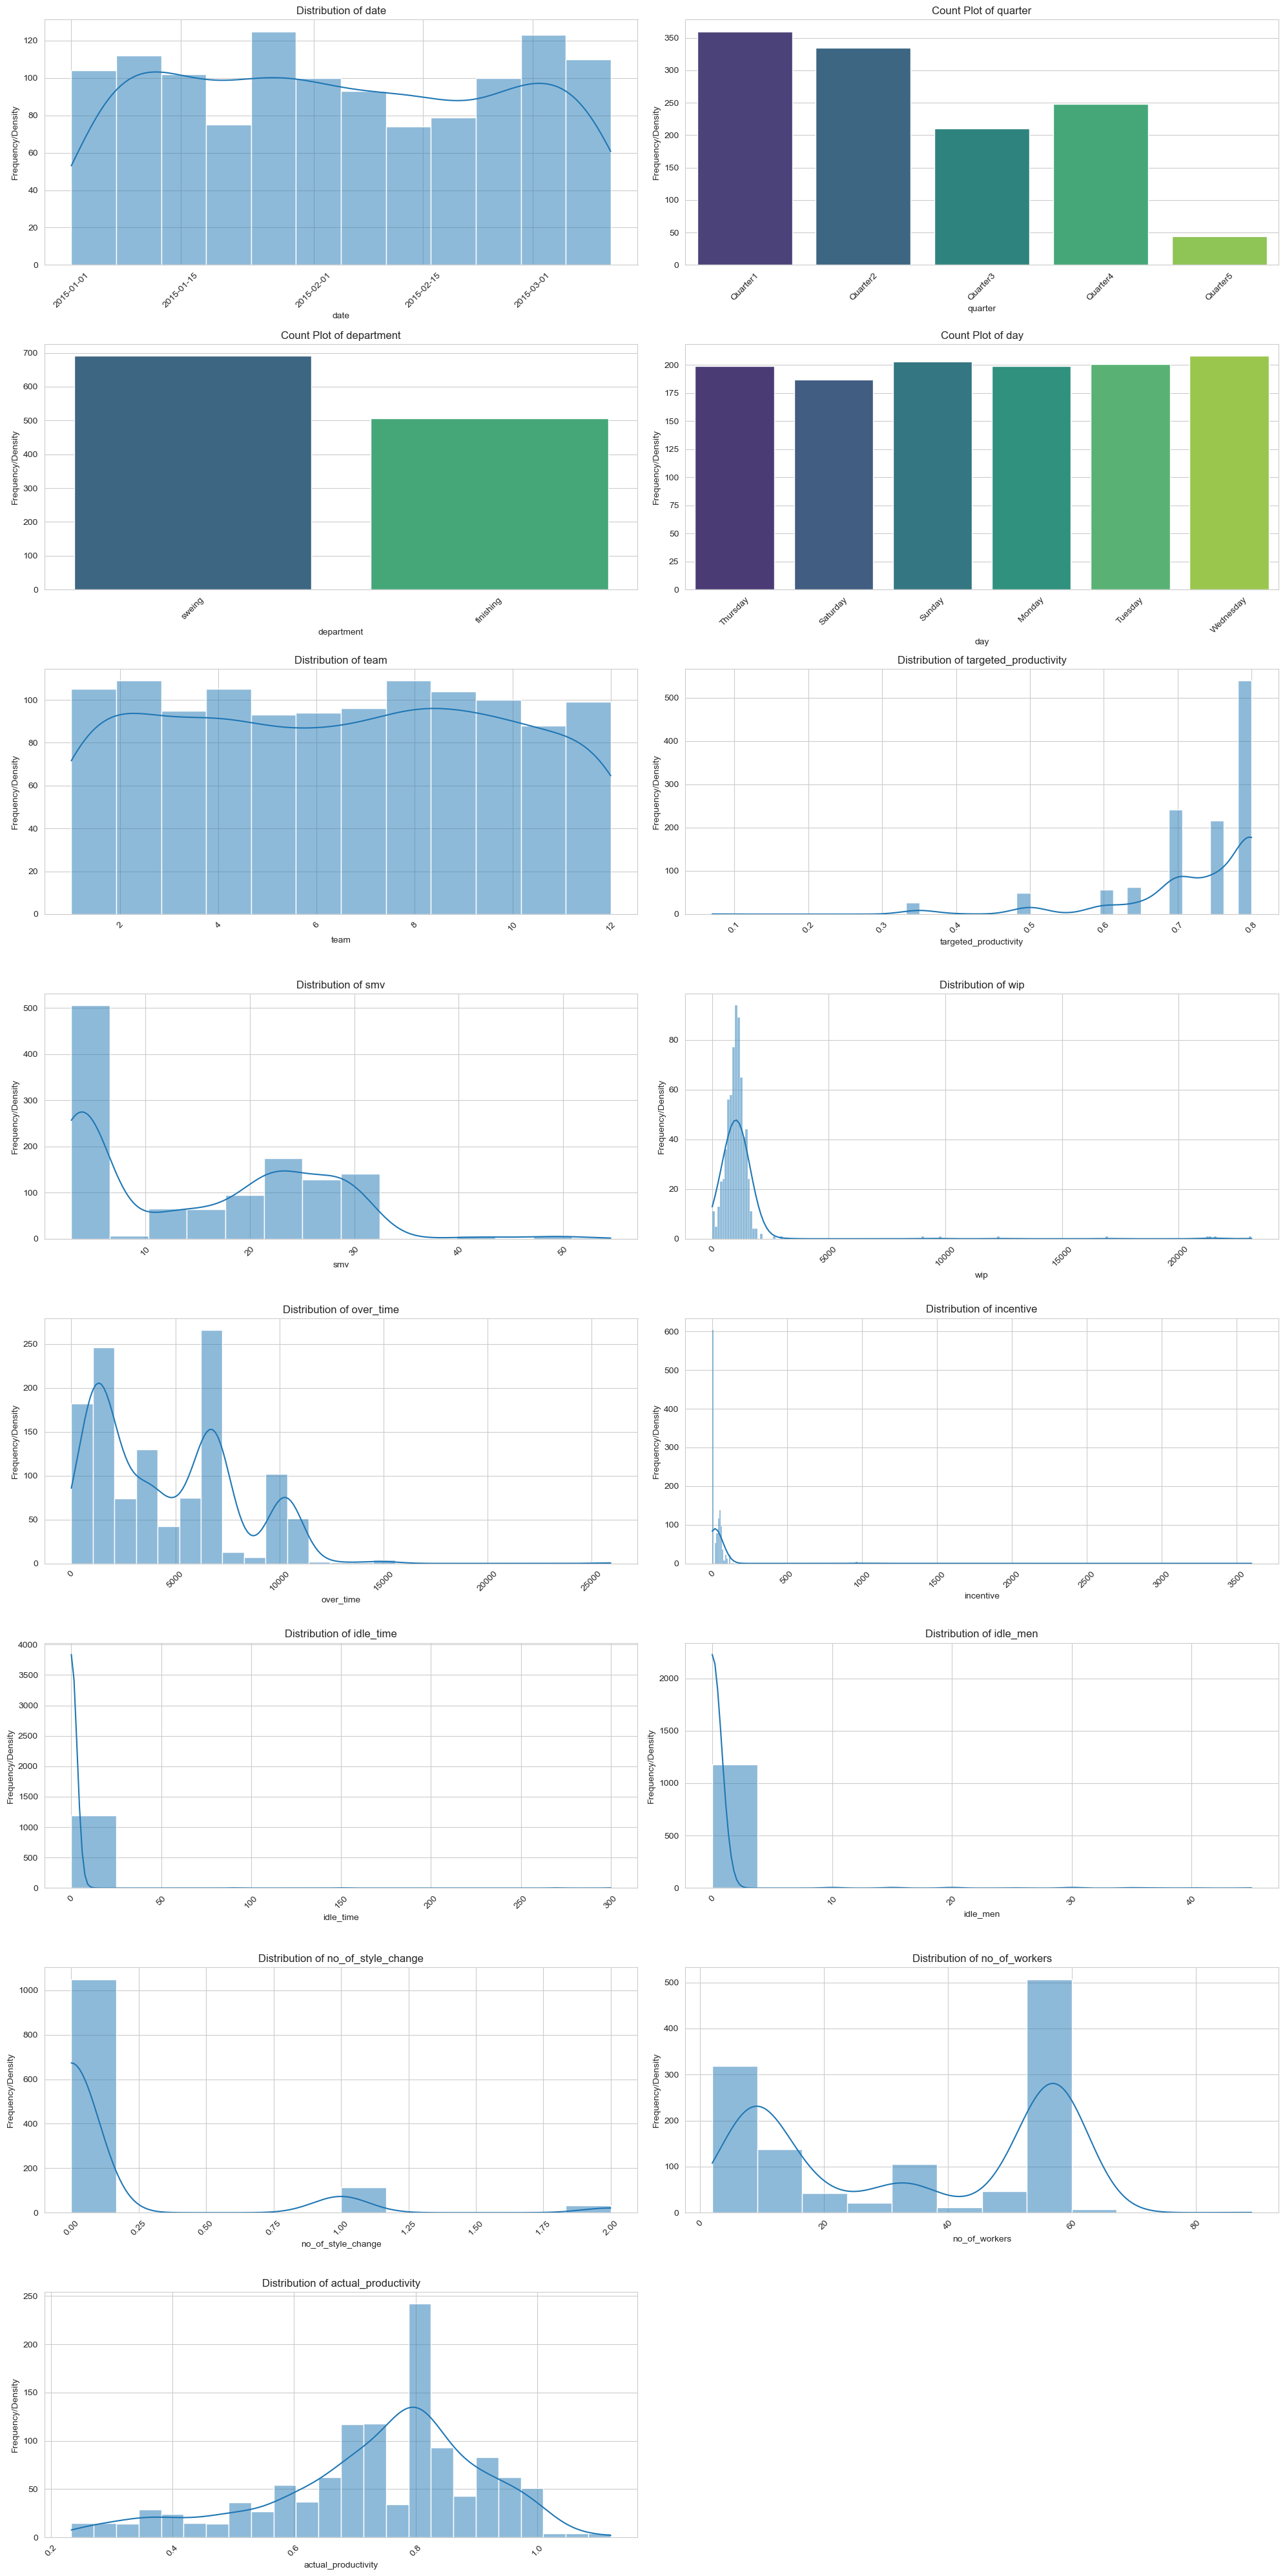

In [10]:
# Function to perform and plot univariate analysis
def univariate_analysis(df, columns_to_analyze=None, figsize=None):
    """
    This function performs univariate analysis for specified or all columns in a DataFrame. 
    It generates appropriate plots (countplot for categorical, histplot for numerical) and displays them in a grid layout.

    Parameters:
        df (pandas.DataFrame): The DataFrame to analyze.
        columns_to_analyze (list, optional): A list of column names to analyze. If None, analyzes all columns.
        figsize (tuple, optional): The size of the figure to display the plots (width, height).

    Returns:
        None: Displays the plots.
    """
    
    # Set the aesthetic style of the plots (optional)
    sns.set_style("whitegrid")

    # If no specific columns are provided, analyze all
    if columns_to_analyze is None:
        columns_to_analyze = df.columns

    if figsize is None:
        figsize = (20, 5 * ((len(columns_to_analyze) + 1) // 2))

    # Calculate number of rows and columns for the subplot grid
    num_plots = len(columns_to_analyze)
    num_rows = (num_plots + 1) // 2
    num_cols = 2

    # Create the subplots
    fig, axes = plt.subplots(num_rows, num_cols, figsize=figsize)
    axes = axes.flatten()  # Flatten the array for easy iteration

    # Function for individual plot generation
    def plot_single_variable(data, column, ax):
        if data[column].dtype == 'object':
            sns.countplot(data=data, x=column, palette='viridis', ax=ax)
            ax.set_title(f'Count Plot of {column}')
        else:
            sns.histplot(data[column], kde=True, ax=ax)
            ax.set_title(f'Distribution of {column}')
        ax.set_xlabel(column)
        ax.set_ylabel('Frequency/Density')
        ax.tick_params(axis='x', rotation=45)

    # Generate plots for each column
    for i, column in enumerate(columns_to_analyze):
        plot_single_variable(df, column, axes[i])

    # Remove any extra empty subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    # Adjust layout for better readability
    plt.tight_layout()

    # Show the plots
    plt.show()

univariate_analysis(productivity_df)

## Understanding Quarters

In [11]:
# Calculate the number of unique days
num_days = productivity_df['date'].nunique()

# Get the date range
start_date = productivity_df['date'].min()
end_date = productivity_df['date'].max()

# Calculate the total date range
date_range = end_date - start_date

print(f"The data covers {num_days} unique days.")
print(f"Date range: from {start_date.date()} to {end_date.date()}")
print(f"Total time span: {date_range.days + 1} days")

The data covers 59 unique days.
Date range: from 2015-01-01 to 2015-03-11
Total time span: 70 days


In [12]:
# Group by quarter and get the date range for each
quarter_ranges = productivity_df.groupby('quarter').agg({
    'date': ['min', 'max']
})

# Flatten the column names
quarter_ranges.columns = ['start_date', 'end_date']

# Sort by start date to see the progression
quarter_ranges = quarter_ranges.sort_values('start_date')

# Calculate the number of days in each quarter
quarter_ranges['days'] = (quarter_ranges['end_date'] - quarter_ranges['start_date']).dt.days + 1

# Calculate the number of data points in each quarter
quarter_counts = productivity_df['quarter'].value_counts().sort_index()

# Add the count to our results
quarter_ranges['data_points'] = quarter_counts

print("Quarter Date Ranges:")
print(quarter_ranges)

# Calculate any gaps between quarters
gaps = []
for i in range(len(quarter_ranges) - 1):
    current_end = quarter_ranges.iloc[i]['end_date']
    next_start = quarter_ranges.iloc[i+1]['start_date']
    gap = (next_start - current_end).days - 1
    if gap > 0:
        gaps.append(f"Gap of {gap} days between {quarter_ranges.index[i]} and {quarter_ranges.index[i+1]}")

if gaps:
    print("\nGaps between quarters:")
    for gap in gaps:
        print(gap)
else:
    print("\nNo gaps between quarters.")

Quarter Date Ranges:
         start_date   end_date  days  data_points
quarter                                          
Quarter1 2015-01-01 2015-03-07    66          360
Quarter2 2015-01-08 2015-03-11    63          335
Quarter3 2015-01-15 2015-02-19    36          210
Quarter4 2015-01-22 2015-02-28    38          248
Quarter5 2015-01-29 2015-01-31     3           44

No gaps between quarters.


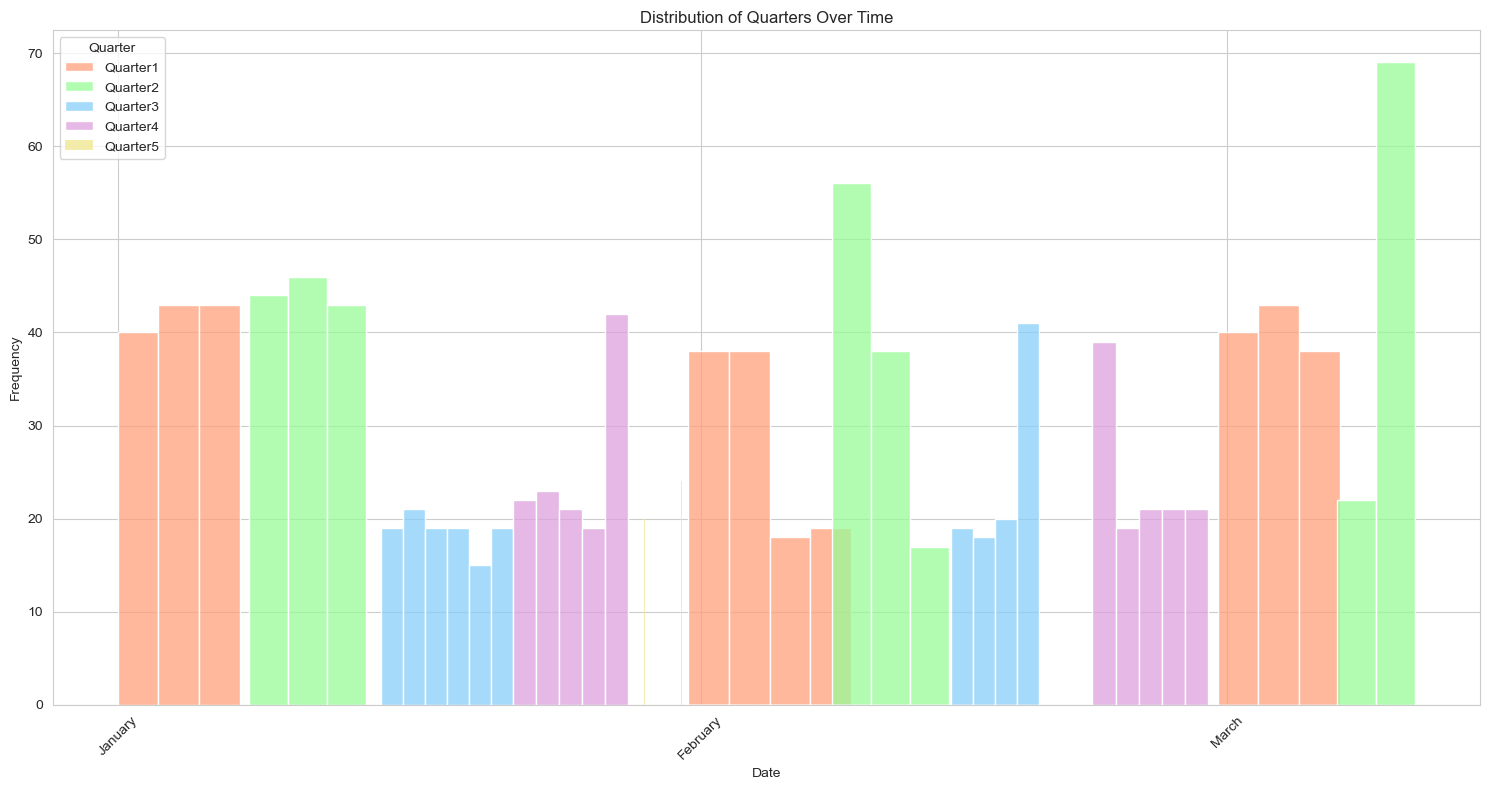

Date range of each quarter:
Quarter1: 2015-01-01 to 2015-03-07
Quarter2: 2015-01-08 to 2015-03-11
Quarter3: 2015-01-15 to 2015-02-19
Quarter4: 2015-01-22 to 2015-02-28
Quarter5: 2015-01-29 to 2015-01-31


In [14]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
import seaborn as sns

# Ensure the date is in datetime format
productivity_df['date'] = pd.to_datetime(productivity_df['date'])

# Create the plot
plt.figure(figsize=(15, 8))

# Define colors for quarters
color_map = {'Quarter1': '#FFA07A', 'Quarter2': '#98FB98', 'Quarter3': '#87CEFA', 
             'Quarter4': '#DDA0DD', 'Quarter5': '#F0E68C'}

# Create histograms for each quarter
for quarter in sorted(productivity_df['quarter'].unique()):
    quarter_data = productivity_df[productivity_df['quarter'] == quarter]
    sns.histplot(data=quarter_data, x='date', bins=30, 
                 color=color_map[quarter], label=quarter, 
                 kde=False, element="bars")

plt.title('Distribution of Quarters Over Time')
plt.xlabel('Date')
plt.ylabel('Frequency')

# Format x-axis to show month names
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%B'))
plt.xticks(rotation=45)

plt.legend(title='Quarter')
plt.tight_layout()
plt.show()

# Print some additional information
print("Date range of each quarter:")
for quarter in sorted(productivity_df['quarter'].unique()):
    quarter_data = productivity_df[productivity_df['quarter'] == quarter]
    print(f"{quarter}: {quarter_data['date'].min().strftime('%Y-%m-%d')} to {quarter_data['date'].max().strftime('%Y-%m-%d')}")

In [15]:
# Change 'Quarter5' to 'Quarter4' 
productivity_df['quarter'] = productivity_df['quarter'].replace('Quarter5', 'Quarter4')

## Correlation Analysis

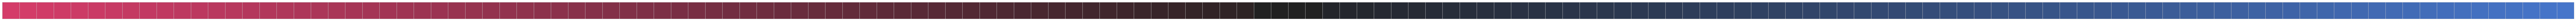

In [21]:
#defining color palette
sns.palplot(sns.diverging_palette(0, 255, sep=8, n=150, center='dark'))

main_facecolor = '#FFFFFF'
main_facecolor2 = '#0D0D0D'
cmap1 = sns.diverging_palette(230, 20, as_cmap=True)
cmap2 = ["#e27c7c", "#a86464", "#6d4b4b", "#503f3f", "#333333", "#3c4e4b", "#466964", "#599e94", "#6cd4c5"]
cmap3 = sns.diverging_palette(0, 255, sep=1, n=50, center='dark')

In [22]:
def is_binary(series, unique_tol=2):
    return series.nunique() <= unique_tol

def mixed_corr(df):
    corr_matrix = pd.DataFrame(index=df.columns, columns=df.columns)
    
    for col1 in df.columns:
        for col2 in df.columns:
            try:
                if is_binary(df[col1]) and is_binary(df[col2]):
                    # Both are binary
                    corr_val = df[col1].corr(df[col2], method='pearson')
                elif is_binary(df[col1]) or is_binary(df[col2]):
                    # One is binary and the other is continuous
                    binary_col = col1 if is_binary(df[col1]) else col2
                    cont_col = col2 if is_binary(df[col1]) else col1
                    corr_val = pointbiserialr(df[cont_col], df[binary_col])[0]
                else:
                    # Both are continuous
                    corr_val = df[col1].corr(df[col2])
                
                corr_matrix.at[col1, col2] = corr_val
            except Exception as e:
                print(f"An error occurred while processing {col1} and {col2}: {e}")
    return corr_matrix

def enforce_symmetry(df):
    return (df + df.T)/2


def plot_heatmap(data, title, figsize=(16, 10)):
    mask = np.triu(np.ones_like(data, dtype=bool))
    fig, ax = plt.subplots(figsize=figsize, facecolor=main_facecolor)
    ax.set_facecolor('#f0f0f0')
    ax.grid(False)
    ax.set_title(title, fontsize=14, fontweight='semibold', fontfamily='sans-serif', color="#413f42",
                 bbox=dict(facecolor='#f0f0f0', edgecolor='#d5d3d6', boxstyle='round,pad=0.6', alpha=0.6))

    _ = sns.heatmap(data, cmap=cmap3, vmax=1, vmin=-1, center=0, square=True, annot=True, linewidths=.5,
                    linecolor='#f0f0f0', cbar_kws={"shrink": .5}, annot_kws={"size": 8}, fmt=".2f")

In [23]:
#creating clustered correlation matrix
df_numeric = productivity_df.select_dtypes(include=['int64', 'float64', 'int32', 'float32'])
mixed_corr_matrix = mixed_corr(df_numeric)

dissimilarity = 1 - abs(mixed_corr_matrix)

# Enforce symmetry
symmetric_dissimilarity = enforce_symmetry(dissimilarity)

# Set diagonal to zero
np.fill_diagonal(symmetric_dissimilarity.values, 0)

# Check for symmetry
print((symmetric_dissimilarity.T == symmetric_dissimilarity).all().all())

# Proceed with clustering
Z = linkage(squareform(symmetric_dissimilarity), 'ward')

#Clusterize the data
threshold = 0.8
labels = fcluster(Z, threshold, criterion='distance')

# Keep the indices to sort labels
labels_order = np.argsort(labels)

# Build a new dataframe with the sorted columns
for idx, i in enumerate(df_numeric.columns[labels_order]):
    if idx == 0:
        clustered = pd.DataFrame(df_numeric[i])
    else:
        df_to_append = pd.DataFrame(df_numeric[i])
        clustered = pd.concat([clustered, df_to_append], axis=1)

clustered_corr = clustered.corr()

True


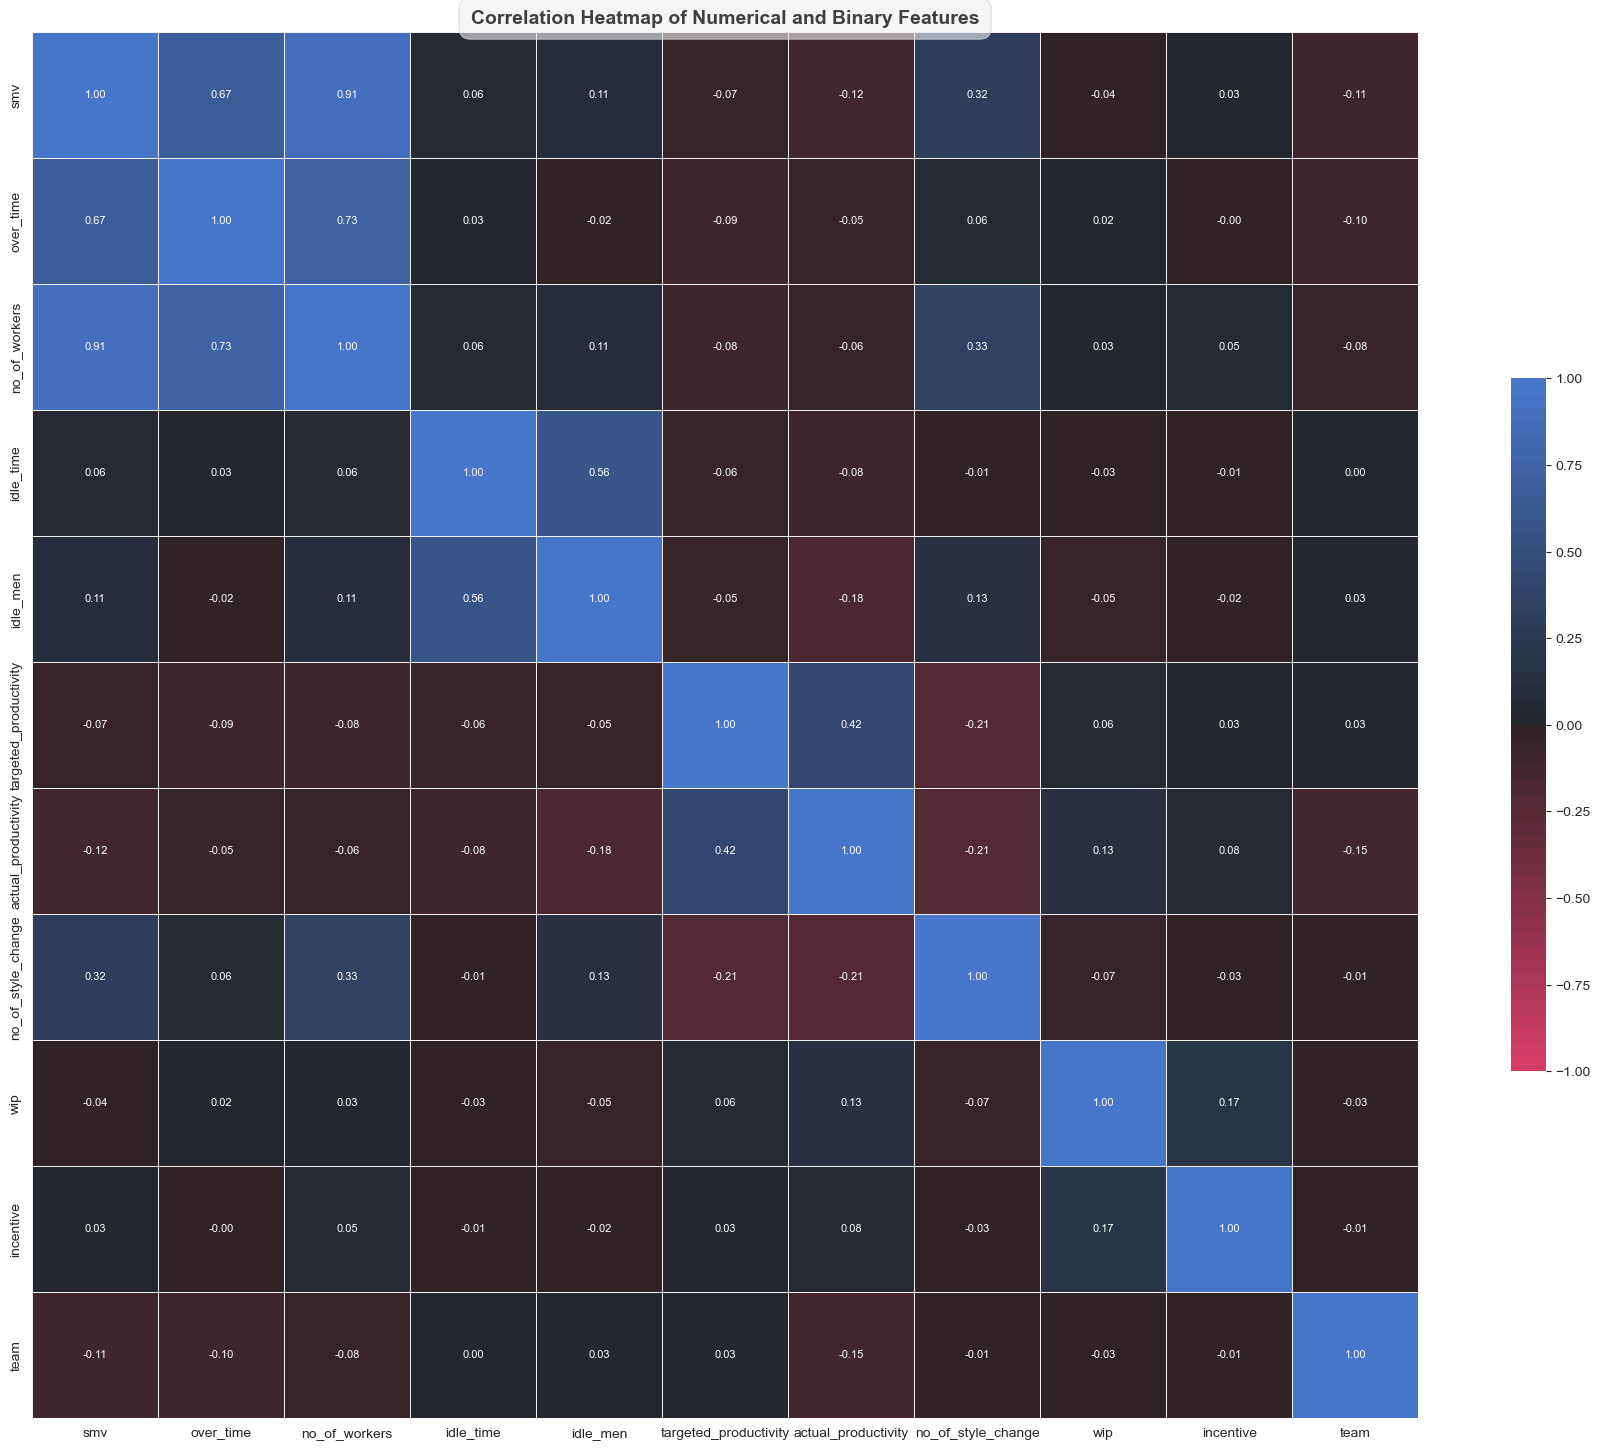

In [24]:
plot_heatmap(clustered_corr.astype(float), title='Correlation Heatmap of Numerical and Binary Features', figsize=(24, 18))

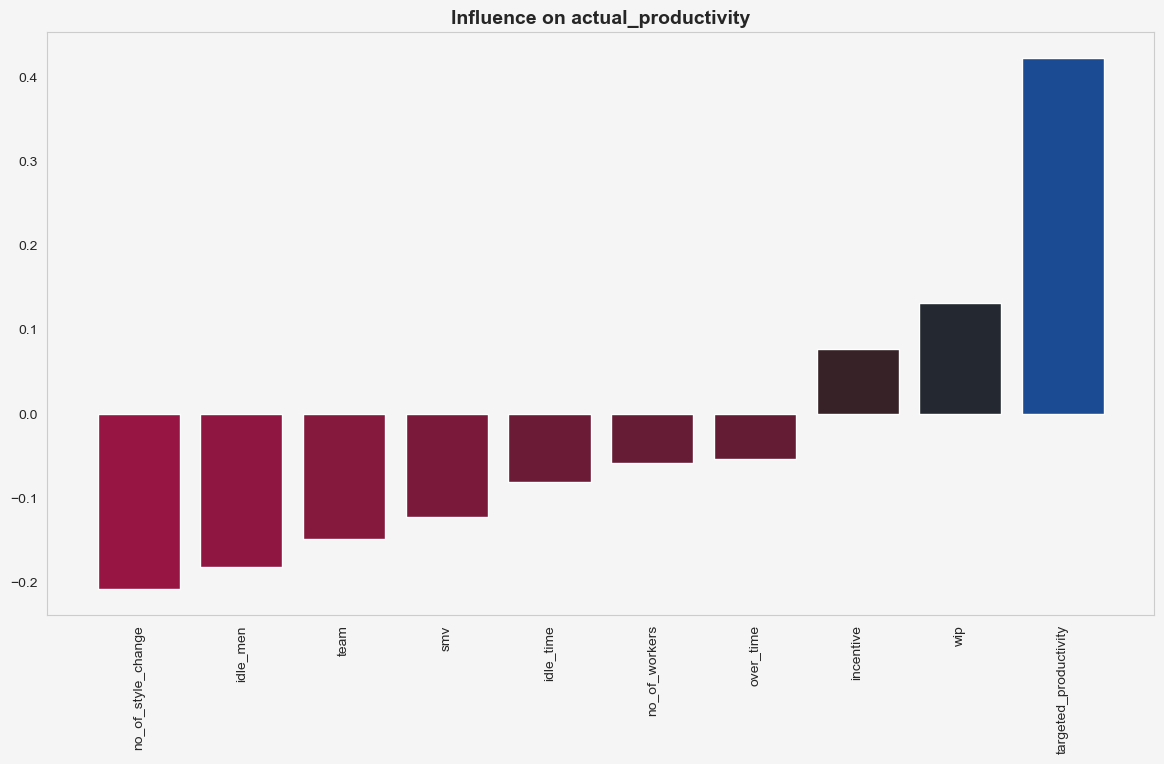

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def plot_df_bar2(df, title, settings, horizontal=False):
    """
    Function to plot a bar chart from a DataFrame.

    Parameters:
    df (pd.Series): DataFrame to plot.
    title (str): Title of the plot.
    settings (dict): Dictionary of settings for the plot.
    horizontal (bool): If True, plots a horizontal bar chart.
    """
    fig, ax = plt.subplots(figsize=settings.get('figsize', (6, 4)))
    
    # Create a diverging palette with red for negative values and blue for positive values
    cmap = sns.diverging_palette(h_neg=0, h_pos=255, s=90, l=33, sep=5, n=120, center='dark', as_cmap=True)
    
    ax.set_facecolor('whitesmoke')
    fig.set_facecolor('whitesmoke')
    
    values = df.values
    norm = plt.Normalize(values.min(), values.max())
    colors = cmap(norm(values))

    if not horizontal:
        ax.bar(df.index, df.values, color=colors, width=settings.get('width', 0.3))
        ax.set_xlabel(settings.get('x_label', ''), fontsize=settings.get('fontsize_axes_label', 14))
        ax.set_ylabel(settings.get('y_label', ''), fontsize=settings.get('fontsize_axes_label', 14))
    else:
        ax.barh(df.index, df.values, color=colors, height=settings.get('width', 0.3))
        ax.set_ylabel(settings.get('x_label', ''), fontsize=settings.get('fontsize_axes_label', 14))
        ax.set_xlabel(settings.get('y_label', ''), fontsize=settings.get('fontsize_axes_label', 14))

    ax.set_title(title, fontsize=settings.get('fontsize_title', 14), fontweight='bold')
    ax.grid(False)

    if horizontal:
        plt.yticks(rotation=settings.get('x_label_rotation', 0))
    else:
        plt.xticks(rotation=settings.get('x_label_rotation', 0))

    plt.tight_layout(pad=2)
    plt.show()

def plot_bar(df, title, horizontal=False, **kwargs):
    """
    Wrapper function to plot a bar chart with custom settings.

    Parameters:
    df (pd.Series): DataFrame to plot.
    title (str): Title of the plot.
    horizontal (bool): If True, plots a horizontal bar chart.
    **kwargs: Additional keyword arguments for settings.
    """
    bar_setting_dict = {
        'x_label': '',
        'y_label': '',
        'figsize': (6, 4),
        'width': 0.3,
        'x_label_rotation': 0,
        'fontsize_title': 14,
        'fontsize_axes_label': 14
    }

    bar_setting_dict.update(kwargs)
    plot_df_bar2(df, title, bar_setting_dict, horizontal=horizontal)

# Example usage:
# Assuming `clustered_corr` is a DataFrame with correlation values.
corr_pairs = clustered_corr.unstack().sort_values()
corr_actualprod = corr_pairs['actual_productivity']
corr_actualprod = corr_actualprod[corr_actualprod.index != 'actual_productivity']

plot_bar(corr_actualprod, title='Influence on actual_productivity', width=0.8, figsize=(12, 8), x_label_rotation=90, horizontal=False)

## Investigate missingness on wip

In [26]:
## Python 
def md_pattern_fun(dat_df):
 # Getting all column names
 all_cols = dat_df.columns.tolist()
 # Getting the names of columns with some missing values
 miss_cols = [col for col in all_cols if dat_df[col].isnull().sum()]
 if miss_cols == all_cols: dat_df['index'] = dat_df.index
 # Removing columns with no missing values
 dat_df = dat_df.loc[:,miss_cols]
 #Showing total number of missing values per variable
 print(dat_df.isnull().sum())
 # Adding count value
 dat_df['count'] = 1
 # Showing count for missingness combinations
 print(dat_df.isnull().groupby(miss_cols).count())

md_pattern_fun(productivity_df)


wip    506
dtype: int64
       count
wip         
False    691
True     506


### missing values sensitivity analysis

There are 40% of missing values in wip, which is significant. A deep analysis will be needed to decide what to do with the missing values, whether to drop, impute, or handle them in another way.
> We will conduct a sensitivity analysis using the following steps:
>
> 1. Identify the Variable with the Most Missing Values:
> 
> - wip has the highest percentage of missing values in the dataset.
>    
> 2. Create Two New Datasets with Extreme Value Imputations:
>
> - Dataset 1: Replace all the missing values in wip with the minimum value of wip.
> - Dataset 2: Replace all the missing values in wip with the maximum value of wip.
>
> 3. Run Regressions:
>
> - Run a regression analysis using the original dataset (with missing values).
> - Run the same regression analysis using Dataset 1 (minimum value imputation).
> - Run the same regression analysis using Dataset 2 (maximum value imputation).
>
> 4. Compare Regression Coefficients:
>
> - Compare the regression coefficients across the three datasets.
> - Assess whether the coefficients are materially different across the three regressions.
>
> 5. Decision Making:
>
> - If the coefficients are not materially different (i.e., the business implications or actions we would take based on the results are the same), we can conclude that the missing data does not significantly affect our analysis, and we can proceed by dropping the missing data.
> - If the coefficients are materially different, it indicates that the missing data has a significant impact, and further steps may be needed to handle the missing data properly.

In [19]:
from sklearn.linear_model import LinearRegression

# Replace missing values with min and max for the sensitivity analysis
min_wip = productivity_df['wip'].min()
max_wip = productivity_df['wip'].max()

# Dataset 1: Replace missing values with minimum value
dataset_min = productivity_df.copy()
dataset_min['wip'].fillna(min_wip, inplace=True)

# Dataset 2: Replace missing values with maximum value
dataset_max = productivity_df.copy()
dataset_max['wip'].fillna(max_wip, inplace=True)

# Original dataset: Drop missing values
dataset_orig = productivity_df.dropna(subset=['wip'])

# Define a function to run the regression and extract coefficients
def run_regression(data, target, predictors):
    X = data[predictors]
    y = data[target]
    model = LinearRegression().fit(X, y)
    return model.coef_

# Define target and predictors
target = 'actual_productivity'  # Replace with your actual target variable
predictors = ['wip', 'incentive', 'targeted_productivity']  # Replace with your actual predictors

# Run regressions
coef_orig = run_regression(dataset_orig, target, predictors)
coef_min = run_regression(dataset_min, target, predictors)
coef_max = run_regression(dataset_max, target, predictors)

# Compare coefficients
print("Original coefficients:", coef_orig)
print("Minimum imputed coefficients:", coef_min)
print("Maximum imputed coefficients:", coef_max)

# Decision Making
if np.allclose(coef_orig, coef_min, atol=0.01) and np.allclose(coef_orig, coef_max, atol=0.01):
    print("The coefficients are not materially different. We can drop the missing data.")
else:
    print("The coefficients are materially different. Further steps are needed to handle the missing data.")

Original coefficients: [3.84348879e-07 3.40924223e-03 6.10052479e-01]
Minimum imputed coefficients: [4.29645282e-06 6.68844745e-05 7.46617423e-01]
Maximum imputed coefficients: [1.12835639e-06 7.18665541e-05 7.38401807e-01]
The coefficients are materially different. Further steps are needed to handle the missing data.


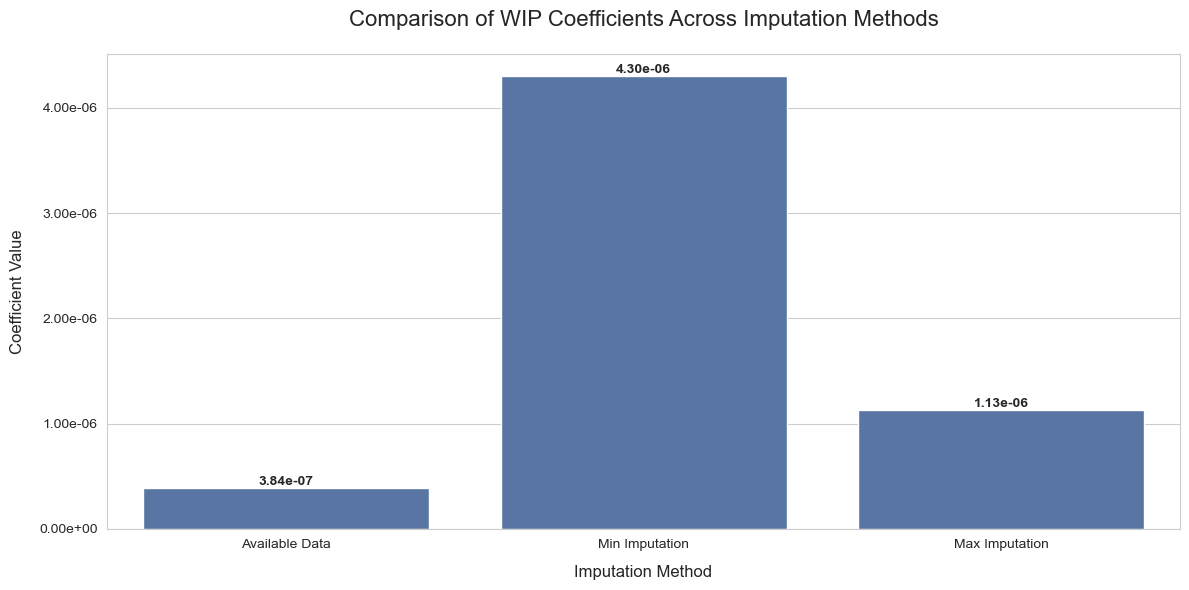

In [31]:
from statsmodels.formula.api import ols

def extract_wip_stats(model):
    results = model.fit()
    return results.params['wip'], results.bse['wip']

# Run regressions and extract statistics
models = {
    'Available Data': ols("actual_productivity ~ wip + incentive + targeted_productivity", data=productivity_df),
    'Min Imputation': ols("actual_productivity ~ wip + incentive + targeted_productivity ", data=dataset_min),
    'Max Imputation': ols("actual_productivity ~ wip + incentive + targeted_productivity", data=dataset_max)
}

data = pd.DataFrame({
    'Method': models.keys(),
    'Coefficient': [extract_wip_stats(model)[0] for model in models.values()],
    'Std Error': [extract_wip_stats(model)[1] for model in models.values()]
})

# Set the style and color palette
sns.set_style("whitegrid")
sns.set_palette("deep")

# Create the plot
plt.figure(figsize=(12, 6))
ax = sns.barplot(x='Method', y='Coefficient', data=data, 
                 capsize=0.1, errcolor='#2C3E50', errwidth=2)

# Add error bars
# ax.errorbar(x=range(len(data)), y=data['Coefficient'], yerr=data['Std Error'], 
#             fmt='none', c='#2C3E50', capsize=5)

# Customize the plot
ax.set_title('Comparison of WIP Coefficients Across Imputation Methods', fontsize=16, pad=20)
ax.set_xlabel('Imputation Method', fontsize=12, labelpad=10)
ax.set_ylabel('Coefficient Value', fontsize=12, labelpad=10)

# Format y-axis to scientific notation
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x:.2e}'))

# Add value labels on the bars
for i, v in enumerate(data['Coefficient']):
    ax.text(i, v, f'{v:.2e}', ha='center', va='bottom', fontweight='bold')

# Adjust layout and display
plt.tight_layout()
plt.show()

### MCAR Diagnosis

> Missing Completely At Random (MCAR) occurs when data is missing in a truly random manner, unrelated to any observed or unobserved variables. By default, we assume variables are MCAR unless we find evidence suggesting otherwise. In statistical terms, MCAR serves as our null hypothesis. We only reject this assumption if we detect patterns indicating that the data might be Missing At Random (MAR) or Missing Not At Random (MNAR).

To diagnose the nature of missing data in our 'wip' (Work in Progress) variable, we'll employ logistic regression. This will help us determine if the missingness in 'wip' is related to other variables in our dataset, which would indicate that the data is Missing At Random (MAR) rather than Missing Completely At Random (MCAR).

Here's our approach:

1. Create a binary variable: We'll create a new variable that is 1 if 'wip' is missing and 0 if it's present.

2. Perform logistic regression: We'll use this binary variable as the dependent variable in a logistic regression, with other variables in our dataset as predictors.

3. Identify significant predictors: We'll focus on the top 5 variables that have the most significant impact on 'actual_productivity' as predictors for the missing values of 'wip'.

4. Interpret results: If any of these predictors show a statistically significant relationship with the missingness of 'wip', it suggests that the data is MAR.

We're using 'actual_productivity' as a guide for selecting predictors because:

1. Relevance: 'actual_productivity' is likely a key variable in our analysis, so factors influencing it are probably important to our study.

2. Data relationships: Variables strongly related to 'actual_productivity' are likely to be important in the overall data structure and may influence other variables, including 'wip'.

3. Efficiency: By focusing on these top predictors, we streamline our analysis while still capturing the most important potential relationships.

4. Avoiding overfitting: Using all variables could lead to an overly complex model. Selecting the top 5 balances comprehensiveness with model simplicity.

If we find that the missingness in 'wip' is significantly related to other variables, we'll need to use appropriate methods for handling MAR data, such as multiple imputation or maximum likelihood estimation, to avoid bias in our analyses. If no significant relationships are found, we can treat the missing data as MCAR and use simpler methods like complete case analysis or simple imputation techniques.

In [43]:
import statsmodels.formula.api as smf
productivity_df['md_wip'] = productivity_df['wip'].isnull().astype(float)
md_wip_mod =smf.logit('md_wip ~ targeted_productivity + team + no_of_style_change + idle_men',
 data=productivity_df)
md_wip_mod.fit().summary()

         Current function value: 0.601322
         Iterations: 35


c:\Users\ASUS TUF\anaconda3\envs\rpyenv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                 md_wip   No. Observations:                 1197
Model:                          Logit   Df Residuals:                     1192
Method:                           MLE   Df Model:                            4
Date:                Thu, 18 Jul 2024   Pseudo R-squ.:                  0.1172
Time:                        11:13:05   Log-Likelihood:                -719.78
converged:                      False   LL-Null:                       -815.34
Covariance Type:            nonrobust   LLR p-value:                 3.042e-40
=========================================================================================
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                 0.3171      0.512      0.619      0.536      -0.687       1.321
targeted_productivity    -0.2564      0.673     -0.381      0.703      -1.576       1.063
team                     -0.0283      0.018     -1.609      0.108      -0.063       0.006
no_of_style_change      -24.1037   1.65e+04     -0.001      0.999   -3.24e+04    3.24e+04
idle_men                 -4.2665   1.83e+08  -2.33e-08      1.000   -3.59e+08    3.59e+08
=========================================================================================

Possibly complete quasi-separation: A fraction 0.13 of observations can be
perfectly predicted. This might indicate that there is complete
quasi-separation. In this case some parameters will not be identified.
"""

> None of the variables has a large and strongly statistically significant coefficient. In the absence of any other evidence, this suggests that the source of missingness for`wip` is purely random and we’ll treat `wip` as MCAR and simpler methods will be used to deal with the missing values.

### Complete Case Analysis

Original dataset shape: (1197, 17)
Shape after Complete Case Analysis: (691, 17)
Number of rows removed: 506
Percentage of data retained: 57.73%


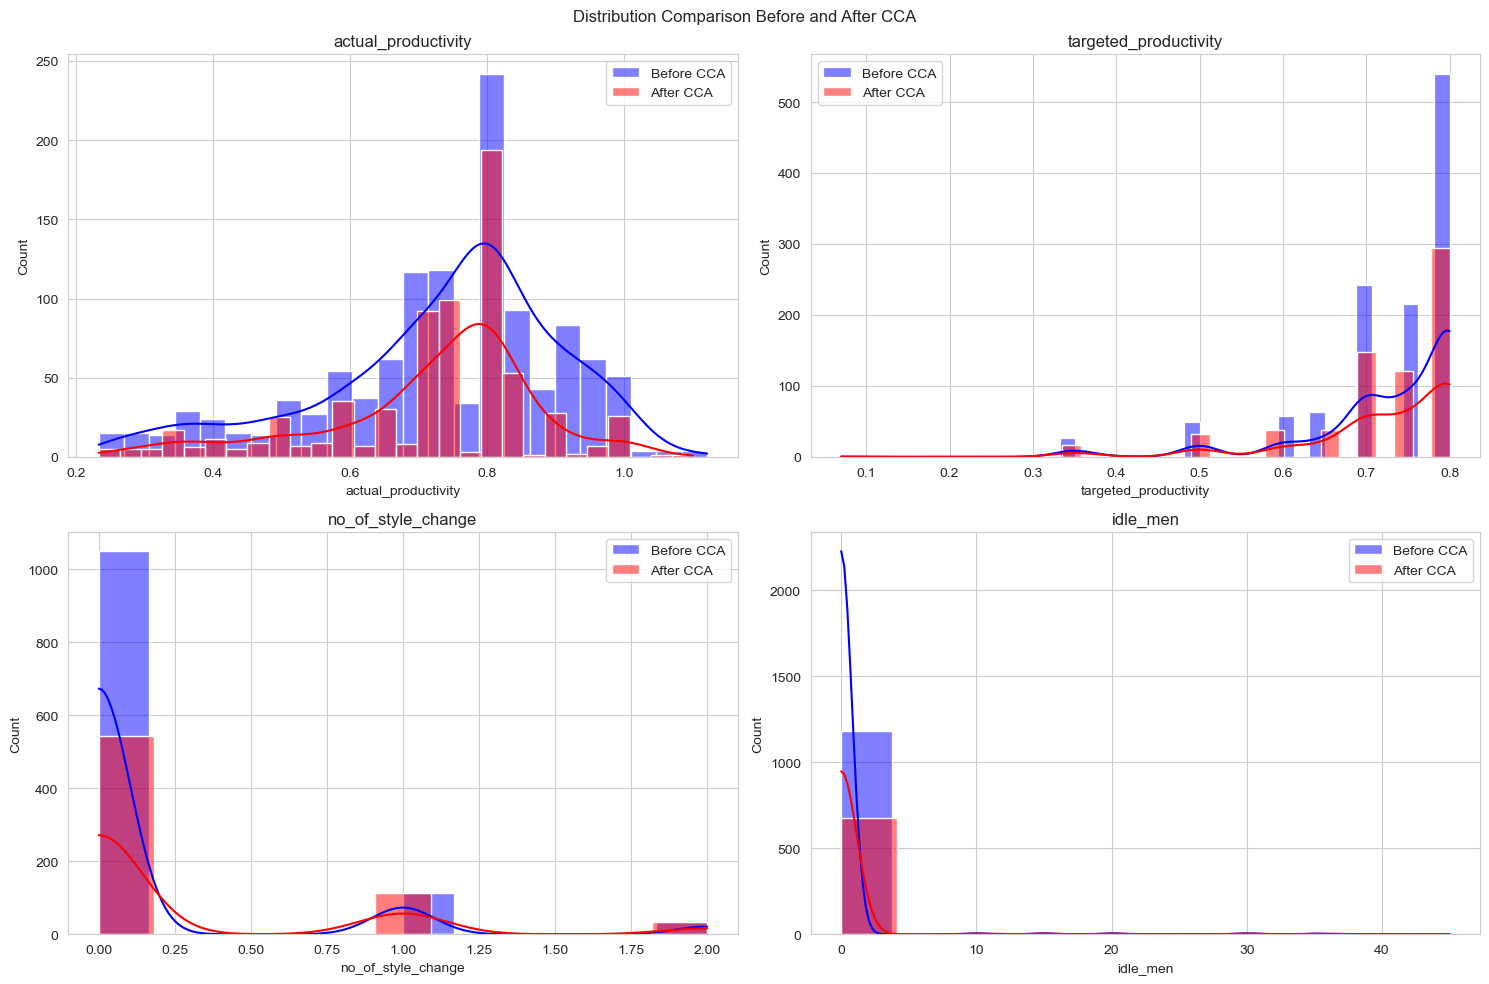


Correlation changes:
                       actual_productivity  targeted_productivity      team  \
actual_productivity               0.000000               0.276376  0.023654   
targeted_productivity             0.276376               0.000000 -0.028889   
team                              0.023654              -0.028889  0.000000   
no_of_style_change               -0.074321              -0.041078 -0.017496   
idle_men                         -0.076623              -0.006212  0.004696   

                       no_of_style_change  idle_men  
actual_productivity             -0.074321 -0.076623  
targeted_productivity           -0.041078 -0.006212  
team                            -0.017496  0.004696  
no_of_style_change               0.000000 -0.023501  
idle_men                        -0.023501  0.000000  


In [46]:
# Perform Complete Case Analysis
variables_of_interest = ['actual_productivity', 'targeted_productivity', 'team', 'no_of_style_change', 'idle_men']
complete_data = productivity_df.dropna(subset='wip')

# Print information about the data before and after CCA
print(f"Original dataset shape: {productivity_df.shape}")
print(f"Shape after Complete Case Analysis: {complete_data.shape}")
print(f"Number of rows removed: {productivity_df.shape[0] - complete_data.shape[0]}")
print(f"Percentage of data retained: {(complete_data.shape[0] / productivity_df.shape[0]) * 100:.2f}%")

# Check for changes in distributions
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle("Distribution Comparison Before and After CCA")

for i, var in enumerate(['actual_productivity', 'targeted_productivity', 'no_of_style_change', 'idle_men']):
    sns.histplot(productivity_df[var], kde=True, ax=axes[i//2, i%2], color='blue', alpha=0.5, label='Before CCA')
    sns.histplot(complete_data[var], kde=True, ax=axes[i//2, i%2], color='red', alpha=0.5, label='After CCA')
    axes[i//2, i%2].set_title(var)
    axes[i//2, i%2].legend()

plt.tight_layout()
plt.show()

# Check for changes in correlation
corr_before = productivity_df[variables_of_interest].corr()
corr_after = complete_data[variables_of_interest].corr()

print("\nCorrelation changes:")
print(corr_after - corr_before)

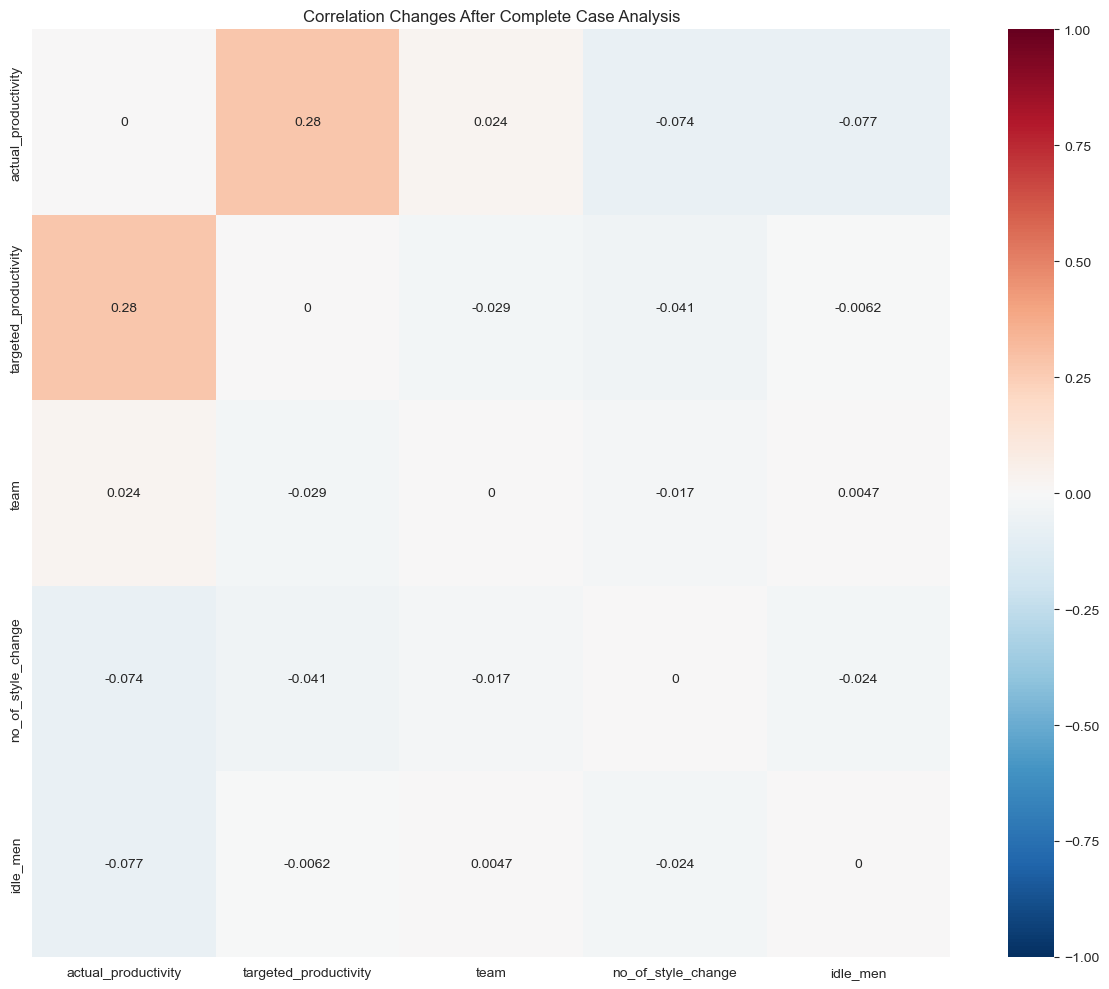

Correlation changes:
                       actual_productivity  targeted_productivity      team  \
actual_productivity               0.000000               0.276376  0.023654   
targeted_productivity             0.276376               0.000000 -0.028889   
team                              0.023654              -0.028889  0.000000   
no_of_style_change               -0.074321              -0.041078 -0.017496   
idle_men                         -0.076623              -0.006212  0.004696   

                       no_of_style_change  idle_men  
actual_productivity             -0.074321 -0.076623  
targeted_productivity           -0.041078 -0.006212  
team                            -0.017496  0.004696  
no_of_style_change               0.000000 -0.023501  
idle_men                        -0.023501  0.000000  


In [49]:
def visualize_correlation_changes(original_data, complete_data, variables_of_interest):
    # Calculate correlations
    corr_before = original_data[variables_of_interest].corr()
    corr_after = complete_data[variables_of_interest].corr()
    
    # Calculate the difference
    corr_diff = corr_after - corr_before
    
    # Create a heatmap
    plt.figure(figsize=(12, 10))
    sns.heatmap(corr_diff, annot=True, cmap='RdBu_r', center=0, vmin=-1, vmax=1)
    plt.title('Correlation Changes After Complete Case Analysis')
    plt.tight_layout()
    plt.show()
    
    return corr_diff

# Define your variables of interest
variables_of_interest = ['actual_productivity', 'targeted_productivity', 'team', 'no_of_style_change', 'idle_men']

# Visualize the correlation changes
corr_changes = visualize_correlation_changes(productivity_df, complete_data, variables_of_interest)

# Print the correlation changes for reference
print("Correlation changes:")
print(corr_changes)

Upon complete case analysis, we can see that completely removing the missing values on wip increased the correlation between actual_productivity and targeted_productivity by 0.28 from 0.42 to 0.70. This indicates that complete removal increase bias of the data due to significantly smaller sample size. this will lead to less reliable estimates of the true population parameters and increase the overfit tendencies of model we will develop later

# Data Splitting

In [5]:
X = productivity_prediction_of_garment_employees.data.features 
y = productivity_prediction_of_garment_employees.data.targets 
  
# metadata 
print(productivity_prediction_of_garment_employees.metadata) 
  
# variable information 
print(productivity_prediction_of_garment_employees.variables) 

{'uci_id': 597, 'name': 'Productivity Prediction of Garment Employees', 'repository_url': 'https://archive.ics.uci.edu/dataset/597/productivity+prediction+of+garment+employees', 'data_url': 'https://archive.ics.uci.edu/static/public/597/data.csv', 'abstract': 'This dataset includes important attributes of the garment manufacturing process and the productivity of the employees which had been collected manually and also been validated by the industry experts.', 'area': 'Business', 'tasks': ['Classification', 'Regression'], 'characteristics': ['Multivariate', 'Time-Series'], 'num_instances': 1197, 'num_features': 14, 'feature_types': ['Integer', 'Real'], 'demographics': [], 'target_col': ['actual_productivity'], 'index_col': None, 'has_missing_values': 'yes', 'missing_values_symbol': 'NaN', 'year_of_dataset_creation': 2020, 'last_updated': 'Mon Feb 26 2024', 'dataset_doi': '10.24432/C51S6D', 'creators': [], 'intro_paper': {'title': 'Mining the productivity data of the garment industry', '